In [1]:
import pandas as pd

In [3]:
df = pd.read_csv("clsvshkrcmt.csv")
df.drop(columns=['Unnamed: 0','Name','year'],inplace=True)
df.head()

,Comments
0,dudes look like nonracially matching twins
1,hey guys begginer chess player little experien...
2,dear chessbase india uninitiated please mentio...
3,cocaine
4,shade alphazero magnus


In [6]:
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data = df.Comments.values.tolist()
data_words = list(sent_to_words(data))

In [7]:
# Build the bigram and trigram models

bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [8]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:
!pip install --upgrade spacy
!python -m spacy download en_core_web_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 3.9 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [11]:
import spacy

# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

[['dude', 'look', 'nonracially', 'match', 'twin']]


In [12]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]]


In [13]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [14]:
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.095*"cough" + 0.061*"guy" + 0.044*"lose" + 0.029*"think" + 0.023*"hear" + '
  '0.020*"sound" + 0.019*"mean" + 0.018*"stalemate" + 0.016*"wonder" + '
  '0.016*"tie"'),
 (1,
  '0.098*"get" + 0.066*"magnus" + 0.044*"right" + 0.041*"wait" + 0.038*"leave" '
  '+ 0.032*"shoulder" + 0.019*"hikaru" + 0.017*"stand" + 0.016*"see" + '
  '0.016*"arch_rival"'),
 (2,
  '0.109*"game" + 0.071*"know" + 0.056*"even" + 0.041*"lol" + 0.035*"coughing" '
  '+ 0.033*"end" + 0.028*"still" + 0.026*"say" + 0.023*"rival" + '
  '0.019*"background"'),
 (3,
  '0.049*"much" + 0.038*"man" + 0.032*"cough" + 0.026*"talk" + 0.025*"love" + '
  '0.024*"need" + 0.021*"whole" + 0.021*"shit" + 0.020*"always" + 0.019*"go"'),
 (4,
  '0.097*"watch" + 0.068*"video" + 0.050*"chess" + 0.043*"comment" + '
  '0.042*"resign" + 0.033*"well" + 0.023*"cough" + 0.020*"explain" + '
  '0.019*"dude" + 0.017*"people"'),
 (5,
  '0.088*"win" + 0.068*"match" + 0.049*"really" + 0.030*"board" + 0.022*"time" '
  '+ 0.018*"many" + 0.016*"

In [15]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4198155798124176


In [19]:
import matplotlib.pyplot as plt


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

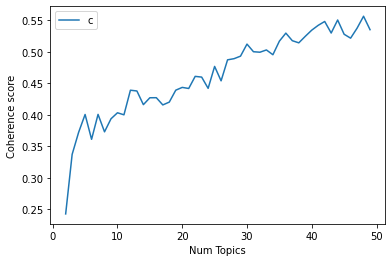

In [42]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=15)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


limit=50; start=2; step=1;
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=50, step=1)
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [43]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.243
Num Topics = 3  has Coherence Value of 0.3375
Num Topics = 4  has Coherence Value of 0.3724
Num Topics = 5  has Coherence Value of 0.4008
Num Topics = 6  has Coherence Value of 0.3614
Num Topics = 7  has Coherence Value of 0.4009
Num Topics = 8  has Coherence Value of 0.3732
Num Topics = 9  has Coherence Value of 0.3939
Num Topics = 10  has Coherence Value of 0.4035
Num Topics = 11  has Coherence Value of 0.4002
Num Topics = 12  has Coherence Value of 0.4393
Num Topics = 13  has Coherence Value of 0.4381
Num Topics = 14  has Coherence Value of 0.4164
Num Topics = 15  has Coherence Value of 0.4273
Num Topics = 16  has Coherence Value of 0.4274
Num Topics = 17  has Coherence Value of 0.4159
Num Topics = 18  has Coherence Value of 0.4204
Num Topics = 19  has Coherence Value of 0.4393
Num Topics = 20  has Coherence Value of 0.4437
Num Topics = 21  has Coherence Value of 0.442
Num Topics = 22  has Coherence Value of 0.4612
Num Topics = 23  has Co

In [44]:
optimal_model = model_list[13]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.062*"player" + 0.062*"good" + 0.052*"chess" + 0.041*"give" + '
  '0.020*"watch" + 0.018*"great" + 0.017*"game" + 0.015*"else" + 0.014*"find" '
  '+ 0.013*"little"'),
 (1,
  '0.047*"shoulder" + 0.039*"say" + 0.027*"hand" + 0.025*"bad" + 0.016*"dirt" '
  '+ 0.016*"jacket" + 0.015*"dirty" + 0.013*"shake" + 0.013*"beard" + '
  '0.012*"fight"'),
 (2,
  '0.046*"nakamura" + 0.029*"think" + 0.022*"board" + 0.019*"first" + '
  '0.018*"checkmate" + 0.016*"see" + 0.016*"put" + 0.013*"get" + '
  '0.012*"magnus" + 0.012*"guess"'),
 (3,
  '0.103*"draw" + 0.071*"wait" + 0.043*"right" + 0.040*"start" + 0.034*"well" '
  '+ 0.029*"dude" + 0.025*"tie" + 0.021*"handshake" + 0.020*"really" + '
  '0.020*"end"'),
 (4,
  '0.119*"chess" + 0.092*"know" + 0.070*"play" + 0.058*"watch" + 0.043*"even" '
  '+ 0.027*"still" + 0.021*"much" + 0.015*"m" + 0.014*"video" + 0.014*"game"'),
 (5,
  '0.229*"look" + 0.039*"guy" + 0.020*"person" + 0.020*"different" + '
  '0.018*"nice" + 0.014*"alike" + 0.014*"similar"

In [31]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 4.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=f493a170c7591a6780f4426c5ddef7fd9e9ea953c80ecfe4be6d21be89ab5602
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [45]:
# import pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models
import pickle 

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(model_list[13], corpus, id2word)
LDAvis_prepared

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.204857  0.050260       1        1  12.875800
8      0.064333  0.274501       2        1  11.488536
12    -0.236278 -0.015668       3        1   8.097533
14    -0.182174 -0.099548       4        1   7.656358
6     -0.086442 -0.024122       5        1   6.705950
0     -0.087647 -0.024133       6        1   6.177897
10     0.063970  0.101285       7        1   6.079763
7      0.101608  0.146955       8        1   6.015118
3      0.108695 -0.045960       9        1   5.875539
5      0.091643 -0.146142      10        1   5.701474
13    -0.039477  0.045907      11        1   5.594255
1      0.093137 -0.006018      12        1   4.905774
11     0.119071 -0.138467      13        1   4.538948
2      0.057600  0.016440      14        1   4.399598
9      0.136817 -0.135291      15        1   3.887457, topic_info=             Term        Freq       Total Category  logprob  loglift
1            look  331.000000  331.000000  Default  30.0000  30.0000
42          cough  492.000000  492.000000  Default  29.0000  29.0000
7           chess  668.000000  668.000000  Default  28.0000  28.0000
91           know  314.000000  314.000000  Default  27.0000  27.0000
153           win  216.000000  216.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
207   interesting   17.451544   27.809633  Topic15  -4.0308   2.7815
2477         dewa    4.668813    6.265602  Topic15  -5.3494   2.9532
46    anyone_else   11.131522   17.786708  Topic15  -4.4805   2.7787
607        defeat    6.158731   10.796169  Topic15  -5.0724   2.6861
176        resign   11.538210   66.194226  Topic15  -4.4446   1.5005

[787 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
5         2  0.901095    able
5         6  0.081918    able
606       7  0.098995  accept
606      10  0.890954  accept
1290      6  0.906160     act
...     ...       ...     ...
288       5  0.895650     wth
910       4  0.675543    year
910      14  0.311789    year
70        8  0.202827     yet
70       13  0.743698     yet

[1141 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 9, 13, 15, 7, 1, 11, 8, 4, 6, 14, 2, 12, 3, 10])